# Synthetic Data Test

In [49]:
from mvlearn.embed.kcca_experimental import KCCA
from mvlearn.embed.dcca import DCCA
from mvlearn.embed.gcca import GCCA

from mvlearn.datasets.GaussianMixture import GaussianMixture
%load_ext autoreload
%autoreload 2

import numpy as np
import collections
import matplotlib.pyplot as plt
from graspy.plot import pairplot
%matplotlib inline
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize Latent Data

In [50]:
## Training
n = 200
mu = [[0,1], [0,-1]]
sigma = 2*[np.eye(2), np.eye(2)]
pi = [0.5,0.5]
GM = GaussianMixture(n,mu,sigma,class_probs=pi)

## Test
GM2 = GaussianMixture(n,mu,sigma,class_probs=pi)

## Point Distribution

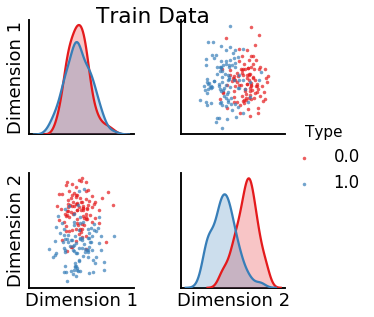

In [51]:
pairplot(GM.latent, GM.y, title='Train Data')

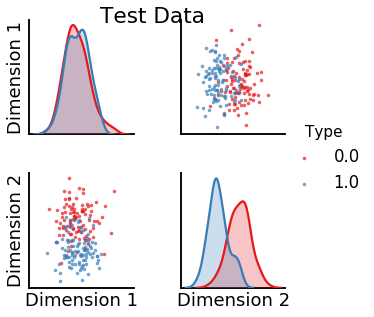

In [52]:
pairplot(GM2.latent, GM2.y, title='Test Data')

## Latent Plotted against itself (ground truth)

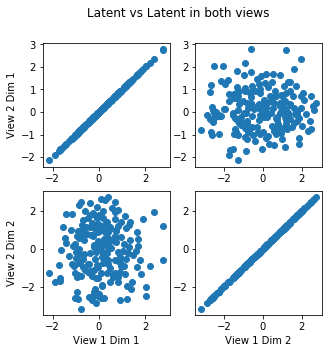

In [53]:
GM.plot_latents(title='Latent vs Latent in both views')

In [54]:
def plot_components(components, method, transformation):
    # We plot dimensions of both views to further show that the first two dimensions are linearly correlated ideally
    n_dim = components[0].shape[1]
    fig,axes = plt.subplots(n_dim,n_dim,figsize=(8,8))
    for i,ax in enumerate(axes.flatten()):
        dim2 = int(i/n_dim)
        dim1 = i % n_dim
        ax.scatter(components[0][:,dim1],components[1][:,dim2])
        #ax.set_title('Dimension 1')
        if dim2 == n_dim-1:
            ax.set_xlabel(f'View 1 Component {dim1+1}')
        if dim1 == 0:
            ax.set_ylabel(f'View 2 Component {dim2+1}')
        ax.set_xticks([])

    plt.suptitle(f'{method} o {transformation} Transform')
    plt.show()

def compare_methods(transform, n_noise=2):
    # Create train/test 2 views. Different data but same seeded transform
    GM.sample_views(transform=transform, n_noise=n_noise, random_states=[1,2])
    GM2.sample_views(transform=transform, n_noise=n_noise, random_states=[3,4])
    
    # Plot 2 views of training data
    GM.plot_2views(title=f'{transform} Transformation of Latents', figsize=(8,8))

    # KCCA Methods
    ktypes = ['linear', 'poly', 'gaussian']
    for ktype in ktypes:
        kcca = KCCA(ktype=ktype, reg = 1.0, n_components = 4, test=True)
        components = kcca.fit(GM.Xs).transform(GM.Xs)
        plot_components(components, ktype + ' KCCA', transform)    
        
    # DCCA
    input_size1, input_size2 = GM.Xs[0].shape[1], GM.Xs[1].shape[1]
    outdim_size = min(GM.Xs[0].shape[1], 4)
    layer_sizes1 = [1024, outdim_size]
    layer_sizes2 = [1024, outdim_size]
    dcca = DCCA(input_size1, input_size2, outdim_size, layer_sizes1, layer_sizes2, epoch_num=100, threshold=0.001)
    dcca = dcca.fit(GM.Xs)
    outputs = dcca.transform(GM2.Xs)
    plot_components(outputs, 'Deep CCA', transform)

def compare_transforms(func, n_noise=2):
    for transform in ['linear', 'poly', 'polyinv', 'sin']:
        # Create train/test 2 views. Different data but same seeded transform
        GM.sample_views(transform=transform, n_noise=n_noise, random_states=[1,2])
        GM2.sample_views(transform=transform, n_noise=n_noise, random_states=[3,4])

        func.fit(GM.Xs)
        outputs = func.transform(GM2.Xs)
    
        plot_components(outputs, f'{transform}', transform)

## Linear Transformation

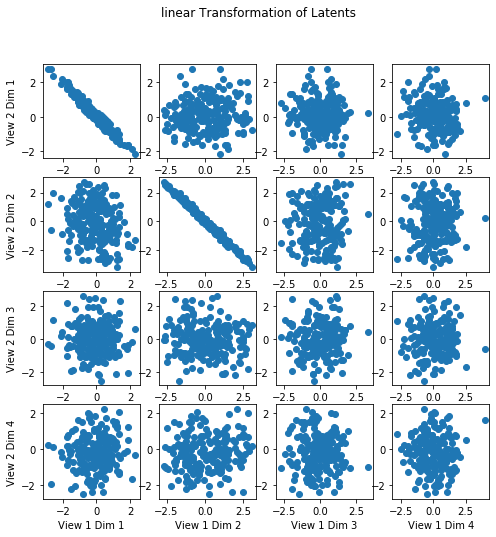

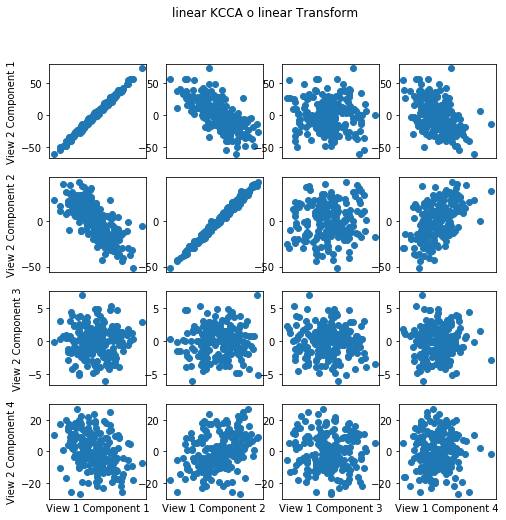

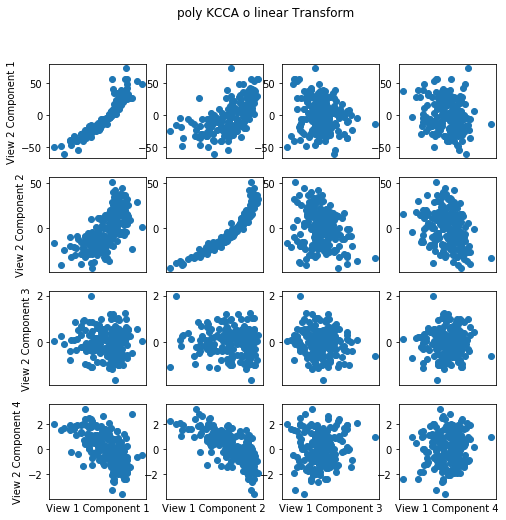

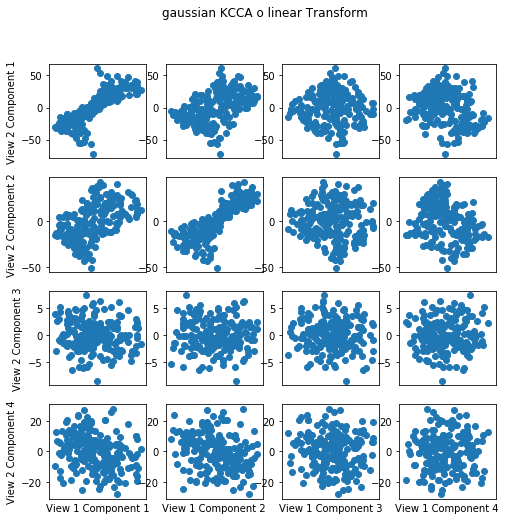

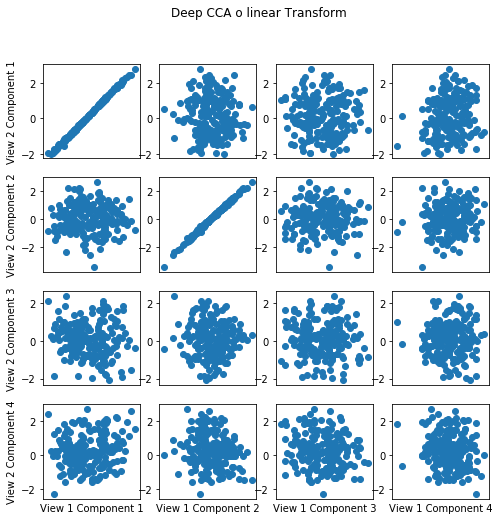

In [55]:
compare_methods('linear')

## Polynomial Transformation

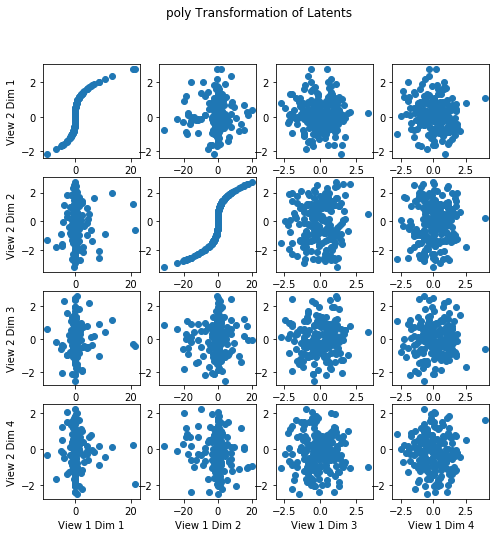

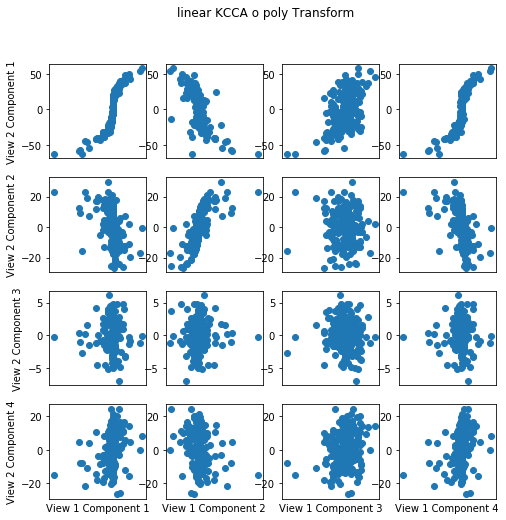

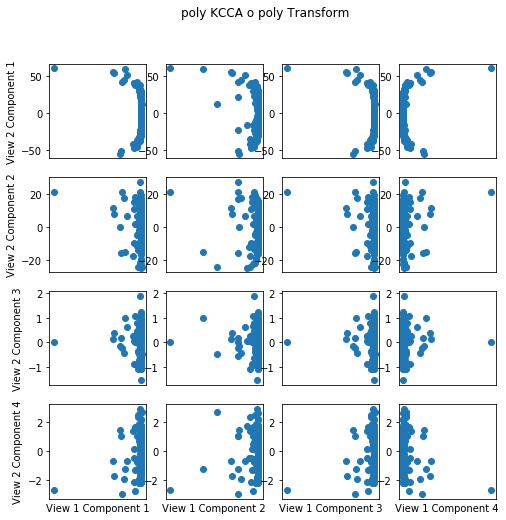

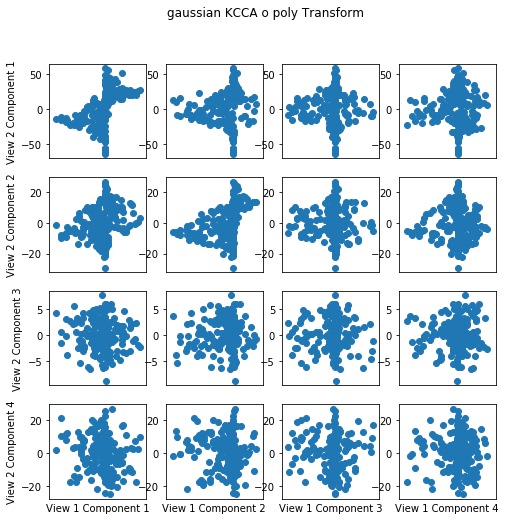

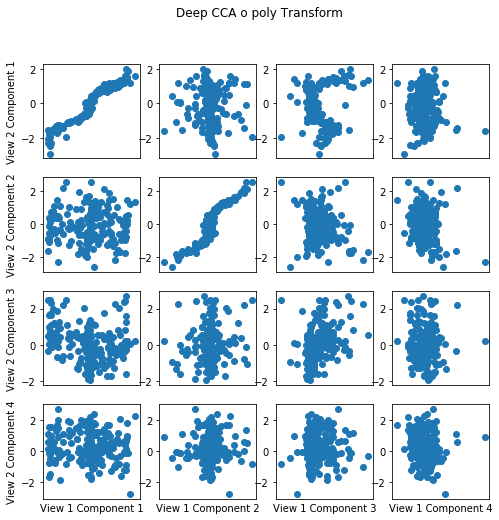

In [57]:
compare_methods('poly')

## Inverse Polynomial Transformation

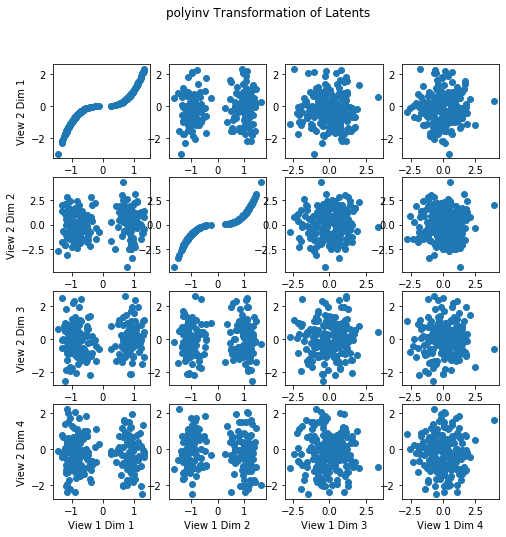

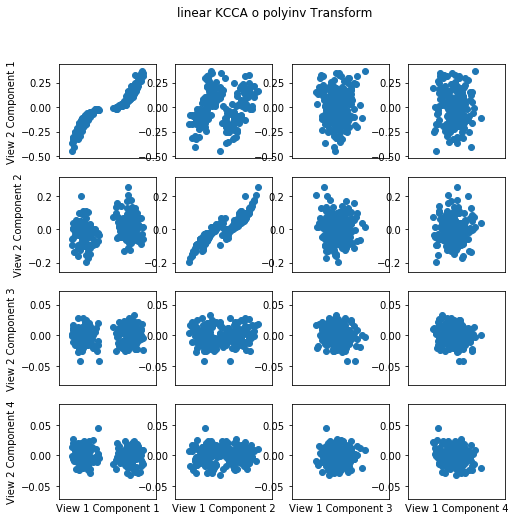

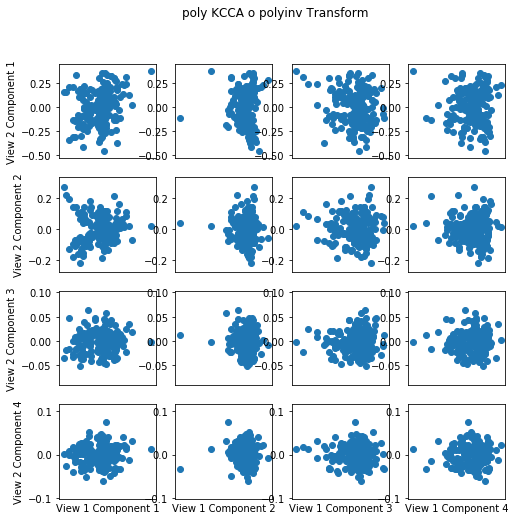

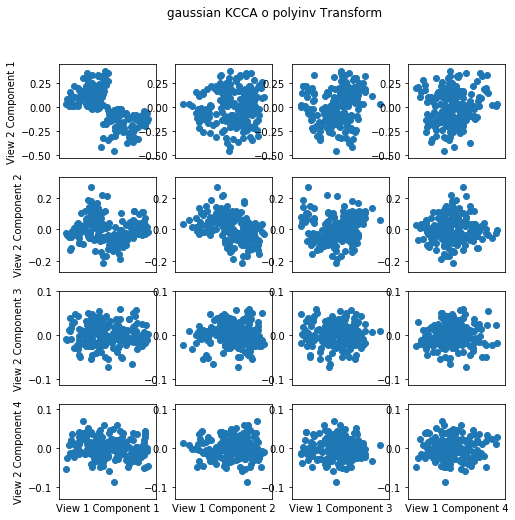

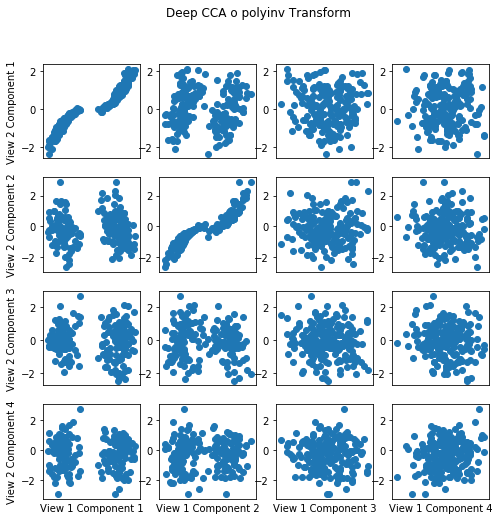

In [131]:
compare_methods('polyinv')

## Sin Transformation

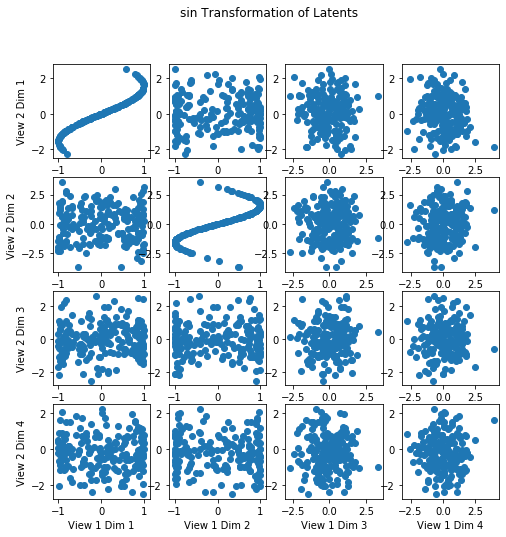

AttributeError: 'list' object has no attribute 'components_'

In [24]:
compare_methods('sin')

## DCCA

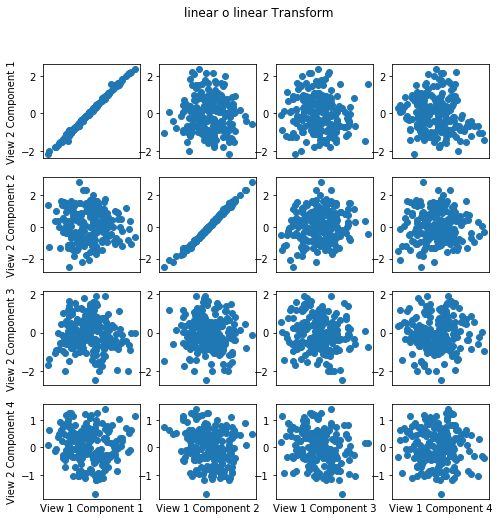

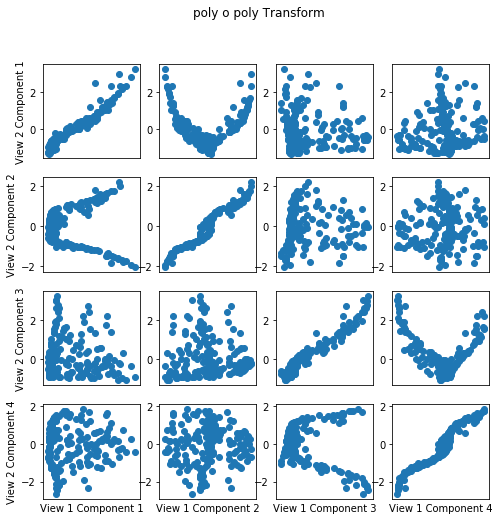

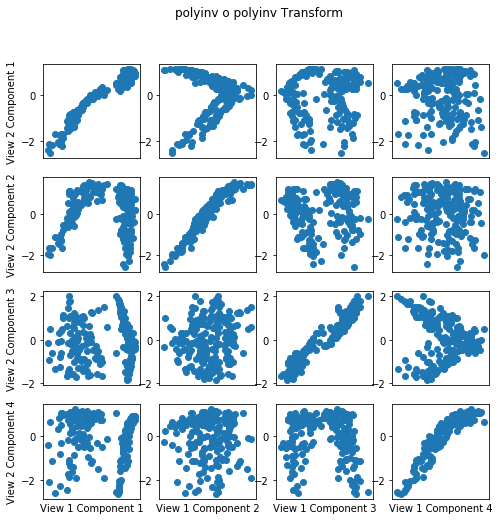

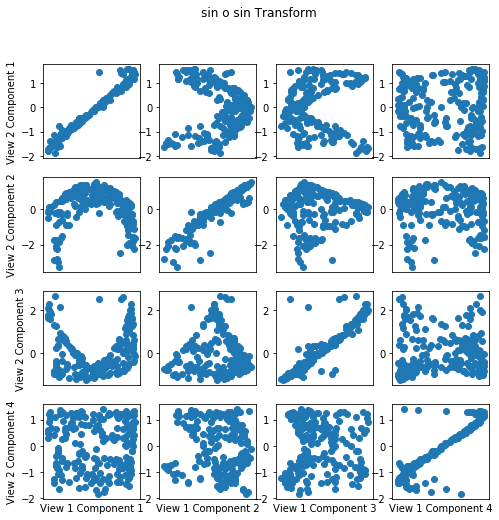

In [28]:
# DCCA
input_size1, input_size2 = 4,4
outdim_size = min(4, 4)
layer_sizes1 = [16,16, outdim_size]
layer_sizes2 = [16,16, outdim_size]
dcca = DCCA(input_size1, input_size2, outdim_size, layer_sizes1, layer_sizes2, epoch_num=1000, threshold=0.001)

compare_transforms(dcca, n_noise=2)